In [37]:
import os
from typing import List
import numpy as np
import wfdb
from wfdb import processing
import random
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

DB_ALIASES = {
    "AFDB": "./../../mit-bih-atrial-fibrillation-database-1.0.0/files",
    "LTAFDB": "./../../long-term-af-database-1.0.0/files",
    "LTAFDB_N": "./../../long-term-af-database-1.0.0/files",
    "NSRDB": "./../../mit-bih-normal-sinus-rhythm-database-1.0.0/files",
}


def clean_annotation(annotation):
    sample, aux_note = annotation.sample, annotation.aux_note
    non_empty_indices = [i for i, note in enumerate(aux_note) if note != ""]
    clean_aux_note = [aux_note[i] for i in non_empty_indices]
    clean_sample = [sample[i] for i in non_empty_indices]
    return clean_sample, clean_aux_note


def get_ranges_afib(
    db_alias: str, record_path: str, signal_len: int
) -> List[List[int]]:
    annotation = wfdb.rdann(record_path, "atr")
    sample, aux_note = clean_annotation(annotation)
    ranges_interest = []

    diagnostic = "(AFIB" if db_alias in ["AFDB", "LTAFDB"] else "(N"

    for i, label in enumerate(aux_note):
        if label == diagnostic:
            afib_start = sample[i]
            afib_end = signal_len if i == len(sample) - 1 else sample[i + 1] - 1
            ranges_interest.append([afib_start, afib_end])

    return ranges_interest


def get_record_ids(db_alias: str) -> List[str]:
    with open(f"{DB_ALIASES[db_alias]}/RECORDS") as f:
        record_ids = [line.strip() for line in f.readlines()]

    if db_alias == "AFDB":
        record_ids.remove("00735")
        record_ids.remove("03665")

    return record_ids


def extract_segments(db_alias):
    record_ids = get_record_ids(db_alias)

    segment_size = 5

    record_ids_size = len(record_ids)

    for record_index, record_id in enumerate(record_ids):
        record_path = os.path.join(DB_ALIASES[db_alias], record_id)
        _, ecg_metadata = wfdb.rdsamp(record_path)
        signal_len = ecg_metadata["sig_len"]

        extract_intervals = (
            get_ranges_afib(db_alias, record_path, signal_len)
            if db_alias in ["AFDB", "LTAFDB", "LTAFDB_N"]
            else [[0, signal_len - 1]]
        )

        rec = wfdb.rdrecord(record_name=record_path)

        stack_rr = np.empty((0, 5), dtype=int)
        stack_recording = []

        print(f"{record_index + 1}/{record_ids_size}")

        for start_index, end_index in tqdm(extract_intervals):
            ann = wfdb.rdann(
                record_path,
                sampfrom=start_index,
                sampto=end_index,
                extension="atr" if db_alias == "NSRDB" else "qrs",
            )

            ann_ms = (ann.sample / ann.fs) * 1000
            rr_interval = processing.calc_rr(ann_ms, fs=ann.fs)
            num_segments = (len(ann.sample) - 1) // segment_size

            if num_segments <= 0:
                continue

            last_segment = num_segments * segment_size

            for i in range(0, last_segment, segment_size):
                start_index = ann.sample[i]
                end_index = ann.sample[i + segment_size]

                rr_segment = rr_interval[i : i + segment_size]
                stack_rr = np.vstack((stack_rr, rr_segment))

                rec_seg = rec.p_signal[start_index:end_index]
                stack_recording.append(rec_seg)

        np.save(
            file=f"./{db_alias}/{record_index}_{record_id}_rri_segment", arr=stack_rr
        )

        stack_recording = np.array(stack_recording, dtype=object)
        np.save(
            file=f"./{db_alias}/{record_index}_{record_id}_recording_segment",
            arr=stack_recording,
        )

In [38]:
folder_path = "./AFDB"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

extract_segments("AFDB")

1/23
30
58
3
7
1
1
2/23
168
25
154
53
10
3
42
45
23
24
23
135
25
39
65
93
51
51
34
23


KeyboardInterrupt: 

In [2]:
folder_path = "./NSRDB"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

extract_segments("NSRDB")

1/18


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


2/18


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


3/18


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


4/18


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


5/18


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


6/18


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


7/18


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


8/18


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


9/18


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


10/18


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


11/18


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


12/18


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


13/18


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


14/18


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


15/18


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


16/18


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


17/18


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


18/18


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [3]:
folder_path = "./LTAFDB"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

extract_segments("LTAFDB")

1/84


100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


2/84


100%|██████████| 53/53 [00:10<00:00,  5.25it/s]


3/84


100%|██████████| 22/22 [00:17<00:00,  1.25it/s]


4/84


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


5/84


100%|██████████| 19/19 [00:02<00:00,  6.37it/s]


6/84


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


7/84


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


8/84


100%|██████████| 80/80 [01:25<00:00,  1.07s/it]


9/84


100%|██████████| 659/659 [07:47<00:00,  1.41it/s]


10/84


100%|██████████| 147/147 [01:20<00:00,  1.82it/s]


11/84


100%|██████████| 43/43 [00:23<00:00,  1.84it/s]


12/84


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


13/84


100%|██████████| 16/16 [00:03<00:00,  4.98it/s]


14/84


100%|██████████| 96/96 [01:04<00:00,  1.48it/s]


15/84


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


16/84


100%|██████████| 22/22 [00:01<00:00, 11.94it/s]


17/84


100%|██████████| 26/26 [00:02<00:00,  9.11it/s]


18/84


100%|██████████| 1042/1042 [00:46<00:00, 22.60it/s]


19/84


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


20/84


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


21/84


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


22/84


100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


23/84


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


24/84


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


25/84


100%|██████████| 87/87 [01:02<00:00,  1.40it/s]


26/84


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


27/84


100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


28/84


100%|██████████| 111/111 [00:47<00:00,  2.35it/s]


29/84


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


30/84


100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


31/84


100%|██████████| 801/801 [10:10<00:00,  1.31it/s]


32/84


100%|██████████| 37/37 [00:46<00:00,  1.27s/it]


33/84


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


34/84


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


35/84


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


36/84


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


37/84


100%|██████████| 19/19 [00:07<00:00,  2.39it/s]


38/84


100%|██████████| 7/7 [00:00<00:00, 21.22it/s]


39/84


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


40/84


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


41/84


100%|██████████| 334/334 [04:54<00:00,  1.13it/s]


42/84


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


43/84


100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


44/84


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


45/84


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


46/84


100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


47/84


100%|██████████| 102/102 [02:02<00:00,  1.20s/it]


48/84


100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


49/84


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


50/84


100%|██████████| 346/346 [02:39<00:00,  2.17it/s]


51/84


100%|██████████| 177/177 [01:45<00:00,  1.67it/s]


52/84


100%|██████████| 106/106 [01:57<00:00,  1.11s/it]


53/84


0it [00:00, ?it/s]


54/84


100%|██████████| 361/361 [04:42<00:00,  1.28it/s]


55/84


100%|██████████| 120/120 [01:54<00:00,  1.05it/s]


56/84


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


57/84


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


58/84


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


59/84


100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


60/84


100%|██████████| 141/141 [01:47<00:00,  1.31it/s]


61/84


100%|██████████| 122/122 [00:55<00:00,  2.19it/s]


62/84


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


63/84


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


64/84


100%|██████████| 82/82 [01:08<00:00,  1.20it/s]


65/84


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


66/84


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


67/84


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


68/84


100%|██████████| 68/68 [00:24<00:00,  2.78it/s]


69/84


100%|██████████| 448/448 [02:15<00:00,  3.29it/s]


70/84


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


71/84


100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


72/84


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


73/84


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


74/84


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


75/84


100%|██████████| 41/41 [00:25<00:00,  1.64it/s]


76/84


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


77/84


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


78/84


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


79/84


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


80/84


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


81/84


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


82/84


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


83/84


100%|██████████| 1044/1044 [15:56<00:00,  1.09it/s]


84/84


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [8]:
folder_path = "./LTAFDB_N"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

extract_segments("LTAFDB_N")

1/84


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


2/84


100%|██████████| 457/457 [00:51<00:00,  8.93it/s]


3/84


100%|██████████| 1648/1648 [14:10<00:00,  1.94it/s]


4/84


100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


5/84


100%|██████████| 48/48 [00:08<00:00,  5.66it/s]


6/84


100%|██████████| 499/499 [04:25<00:00,  1.88it/s]


7/84


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


8/84


100%|██████████| 148/148 [02:35<00:00,  1.05s/it]


9/84


100%|██████████| 839/839 [09:02<00:00,  1.55it/s]


10/84


100%|██████████| 675/675 [04:58<00:00,  2.26it/s]


11/84


100%|██████████| 46/46 [00:23<00:00,  1.93it/s]


12/84


100%|██████████| 2095/2095 [47:21<00:00,  1.36s/it]


13/84


100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


14/84


100%|██████████| 398/398 [03:46<00:00,  1.76it/s]


15/84


0it [00:00, ?it/s]


16/84


100%|██████████| 84/84 [00:46<00:00,  1.80it/s]


17/84


100%|██████████| 52/52 [00:16<00:00,  3.19it/s] 


18/84


100%|██████████| 1055/1055 [00:44<00:00, 23.68it/s]


19/84


100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


20/84


100%|██████████| 132/132 [00:56<00:00,  2.34it/s]


21/84


100%|██████████| 214/214 [01:12<00:00,  2.96it/s]


22/84


100%|██████████| 752/752 [10:10<00:00,  1.23it/s]


23/84


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


24/84


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


25/84


100%|██████████| 340/340 [01:58<00:00,  2.86it/s]


26/84


0it [00:00, ?it/s]


27/84


100%|██████████| 53/53 [00:32<00:00,  1.63it/s]


28/84


100%|██████████| 1335/1335 [07:26<00:00,  2.99it/s]


29/84


100%|██████████| 1078/1078 [06:28<00:00,  2.78it/s]


30/84


100%|██████████| 193/193 [00:46<00:00,  4.19it/s]


31/84


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


32/84


100%|██████████| 117/117 [01:40<00:00,  1.16it/s]


33/84


0it [00:00, ?it/s]


34/84


0it [00:00, ?it/s]


35/84


100%|██████████| 83/83 [00:43<00:00,  1.92it/s]


36/84


0it [00:00, ?it/s]


37/84


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


38/84


0it [00:00, ?it/s]


39/84


0it [00:00, ?it/s]


40/84


0it [00:00, ?it/s]


41/84


0it [00:00, ?it/s]


42/84


0it [00:00, ?it/s]


43/84


0it [00:00, ?it/s]


44/84


0it [00:00, ?it/s]


45/84


0it [00:00, ?it/s]


46/84


0it [00:00, ?it/s]


47/84


100%|██████████| 1636/1636 [25:36<00:00,  1.06it/s]


48/84


100%|██████████| 1194/1194 [09:06<00:00,  2.18it/s]


49/84


100%|██████████| 784/784 [08:58<00:00,  1.46it/s]


50/84


0it [00:00, ?it/s]


51/84


100%|██████████| 93/93 [00:16<00:00,  5.63it/s]


52/84


100%|██████████| 271/271 [04:07<00:00,  1.09it/s]


53/84


100%|██████████| 14/14 [00:02<00:00,  4.84it/s]


54/84


100%|██████████| 541/541 [05:39<00:00,  1.59it/s]


55/84


0it [00:00, ?it/s]


56/84


0it [00:00, ?it/s]


57/84


100%|██████████| 147/147 [01:24<00:00,  1.74it/s]


58/84


100%|██████████| 1447/1447 [05:41<00:00,  4.24it/s]


59/84


100%|██████████| 1236/1236 [11:20<00:00,  1.82it/s]


60/84


100%|██████████| 78/78 [00:24<00:00,  3.22it/s]


61/84


100%|██████████| 56/56 [00:12<00:00,  4.40it/s]


62/84


0it [00:00, ?it/s]


63/84


0it [00:00, ?it/s]


64/84


100%|██████████| 277/277 [02:12<00:00,  2.09it/s]


65/84


100%|██████████| 882/882 [07:28<00:00,  1.97it/s]


66/84


0it [00:00, ?it/s]


67/84


0it [00:00, ?it/s]


68/84


100%|██████████| 348/348 [03:45<00:00,  1.54it/s]


69/84


100%|██████████| 339/339 [01:00<00:00,  5.60it/s]


70/84


0it [00:00, ?it/s]


71/84


100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


72/84


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


73/84


100%|██████████| 928/928 [06:16<00:00,  2.47it/s]


74/84


0it [00:00, ?it/s]


75/84


0it [00:00, ?it/s]


76/84


0it [00:00, ?it/s]


77/84


0it [00:00, ?it/s]


78/84


0it [00:00, ?it/s]


79/84


0it [00:00, ?it/s]


80/84


0it [00:00, ?it/s]


81/84


0it [00:00, ?it/s]


82/84


100%|██████████| 72/72 [00:27<00:00,  2.64it/s]


83/84


100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


84/84


0it [00:00, ?it/s]


['15_07879_rri_segment.npy',
 '19_08378_rri_segment.npy',
 '4_04746_rri_segment.npy',
 '13_07162_rri_segment.npy',
 '17_08215_rri_segment.npy',
 '8_05121_rri_segment.npy',
 '12_06995_rri_segment.npy',
 '2_04048_rri_segment.npy',
 '16_07910_rri_segment.npy',
 '0_04015_rri_segment.npy',
 '5_04908_rri_segment.npy',
 '18_08219_rri_segment.npy',
 '3_04126_rri_segment.npy',
 '9_05261_rri_segment.npy',
 '6_04936_rri_segment.npy',
 '10_06426_rri_segment.npy',
 '11_06453_rri_segment.npy',
 '20_08405_rri_segment.npy',
 '21_08434_rri_segment.npy',
 '22_08455_rri_segment.npy',
 '1_04043_rri_segment.npy',
 '7_05091_rri_segment.npy',
 '14_07859_rri_segment.npy']

In [59]:
import numpy as np
import os

recordings = os.listdir("LTAFDB")
recordings = list(filter(lambda x: x.split("_")[2] != "rri", recordings))

counting = 0

for r in recordings:
    d = np.load(f"./LTAFDB/{r}", allow_pickle=True).shape[0]
    counting += d

counting

618183

In [54]:
recordings

['22_08455_recording_segment.npy',
 '10_06426_recording_segment.npy',
 '5_04908_recording_segment.npy',
 '9_05261_recording_segment.npy',
 '1_04043_recording_segment.npy',
 '18_08219_recording_segment.npy',
 '6_04936_recording_segment.npy',
 '8_05121_recording_segment.npy',
 '7_05091_recording_segment.npy',
 '17_08215_recording_segment.npy',
 '15_07879_recording_segment.npy',
 '13_07162_recording_segment.npy',
 '21_08434_recording_segment.npy',
 '20_08405_recording_segment.npy',
 '4_04746_recording_segment.npy',
 '16_07910_recording_segment.npy',
 '19_08378_recording_segment.npy',
 '0_04015_recording_segment.npy',
 '3_04126_recording_segment.npy',
 '14_07859_recording_segment.npy',
 '2_04048_recording_segment.npy',
 '11_06453_recording_segment.npy',
 '12_06995_recording_segment.npy']

In [66]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import os

recordings = os.listdir("LTAFDB")


signal2 = np.load(f"./LTAFDB/{recordings[0]}", allow_pickle=True)

rri = signal2[0]

NameError: name 'vertical_lines_x' is not defined

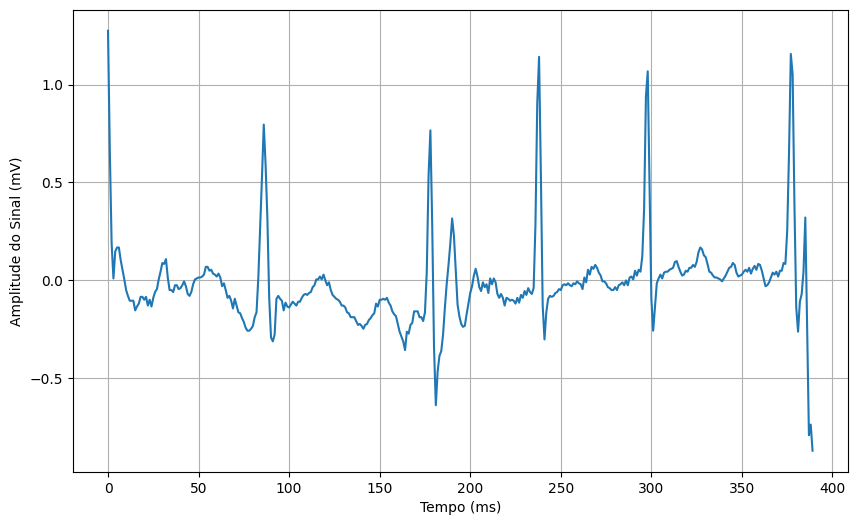

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import os

recordings = os.listdir("LTAFDB")


signal = np.load(f"./LTAFDB/{recordings[2]}", allow_pickle=True)


# Assuming you have a signal stored in a list or numpy array


# If your signal is in a numpy array, you can convert it to a list
# signal = signal.tolist()

signal = signal[3][:, 0]

# Create a time axis (assuming the signal is sampled at regular intervals)
time = np.arange(len(signal))

# Plot the signal
plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude do Sinal (mV)")
plt.grid(True)

for x in vertical_lines_x:
    plt.axvline(x=x, color="r", linestyle="--")
plt.show()

In [24]:
recordings = sorted(os.listdir("NSRDB"))

for rec in recordings:
    signal = np.load(f"./NSRDB/{rec}", allow_pickle=True)
    break

even_positions = [recordings[i] for i in range(len(recordings)) if i % 2 != 0]

len(even_positions)

count = 0

for rec in even_positions:
    signal = np.load(f"./NSRDB/{rec}", allow_pickle=True)
    count += signal.shape[0]
count

361348

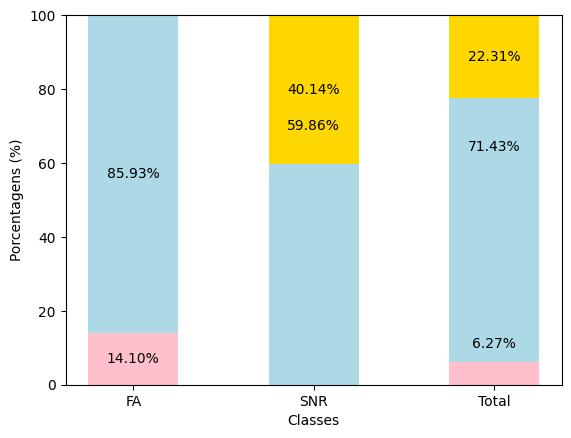

In [9]:
import matplotlib.pyplot as plt

# Data for the chart
data = {
    "AFDB": [14.10, 0, 6.27],
    "LTAFDB": [85.93, 59.86, 71.43],
    "NSRDB": [0, 40.14, 22.31],
}

labels = ["FA", "SNR", "Total"]
bar_width = 0.5

# Create a figure and axis
fig, ax = plt.subplots()
colors = ["#FFC0CB", "#ADD8E6", "#FFD700"]
# Plot the stacked bars
# Plot the stacked bars
bottom = [0, 0, 0]

# Plot the stacked bars
bottom = [0, 0, 0]
for key, values in data.items():
    bars = ax.bar(
        labels, values, label=key, bottom=bottom, width=bar_width, color=colors.pop(0)
    )
    bottom = [sum(x) for x in zip(bottom, values)]

    for bar, value in zip(bars, values):
        if value > 0:  # Show text only for non-zero values
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[0] - value / 2,
                f"{value:.2f}%",
                ha="center",
                va="center",
                color="black",
            )

# Add labels, title, and legend
ax.set_xlabel("Classes")
# Add labels, title, and legend

ax.set_ylabel("Porcentagens (%)")


# Show the plot
plt.show()